# Ejemplo MNIST

Trabajando este ejemplo: https://lux.csail.mit.edu/stable/tutorials/beginner/4_SimpleChains

In [1]:
using Lux, MLUtils, Optimisers, Zygote, OneHotArrays, Random, Statistics, Printf, Reactant
using MLDatasets: MNIST
using SimpleChains: SimpleChains

Reactant.set_default_backend("cpu")

2025-05-06 19:46:12.359114: I external/xla/xla/service/service.cc:152] XLA service 0x286694a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-06 19:46:12.359138: I external/xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1746582372.359396  346939 se_gpu_pjrt_client.cc:1040] Using BFC allocator.
I0000 00:00:1746582372.359424  346939 gpu_helpers.cc:136] XLA backend allocating 6121439232 bytes on device 0 for BFCAllocator.
I0000 00:00:1746582372.359446  346939 gpu_helpers.cc:177] XLA backend will use up to 2040479744 bytes on device 0 for CollectiveBFCAllocator.
I0000 00:00:1746582372.364369  346939 cuda_dnn.cc:529] Loaded cuDNN version 90400


In [2]:
function loadmnist(batchsize, train_split)
    # Load MNIST
    N = parse(Bool, get(ENV, "CI", "false")) ? 1500 : nothing
    dataset = MNIST(; split=:train)
    if N !== nothing
        imgs = dataset.features[:, :, 1:N]
        labels_raw = dataset.targets[1:N]
    else
        imgs = dataset.features
        labels_raw = dataset.targets
    end

    # Process images into (H, W, C, BS) batches
    x_data = Float32.(reshape(imgs, size(imgs, 1), size(imgs, 2), 1, size(imgs, 3)))
    y_data = onehotbatch(labels_raw, 0:9)
    (x_train, y_train), (x_test, y_test) = splitobs((x_data, y_data); at=train_split)

    return (
        # Use DataLoader to automatically minibatch and shuffle the data
        DataLoader(collect.((x_train, y_train)); batchsize, shuffle=true, partial=false),
        # Don't shuffle the test data
        DataLoader(collect.((x_test, y_test)); batchsize, shuffle=false, partial=false),
    )
end

loadmnist (generic function with 1 method)

In [3]:
lux_model = Chain(
    Conv((5, 5), 1 => 6, relu),
    MaxPool((2, 2)),
    Conv((5, 5), 6 => 16, relu),
    MaxPool((2, 2)),
    FlattenLayer(3),
    Chain(Dense(256 => 128, relu), Dense(128 => 84, relu), Dense(84 => 10)),
)

Chain(
    layer_1 = Conv((5, 5), 1 => 6, relu),  # 156 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Conv((5, 5), 6 => 16, relu),  # 2_416 parameters
    layer_4 = MaxPool((2, 2)),
    layer_5 = FlattenLayer{Static.StaticInt{3}}(static(3)),
    layer_6 = Chain(
        layer_1 = Dense(256 => 128, relu),  # 32_896 parameters
        layer_2 = Dense(128 => 84, relu),  # 10_836 parameters
        layer_3 = Dense(84 => 10),      # 850 parameters
    ),
)         # Total: 47_154 parameters,
          #        plus 0 states.

In [4]:
adaptor = ToSimpleChainsAdaptor((28, 28, 1))
simple_chains_model = adaptor(lux_model)

SimpleChainsLayer(
    Chain(
        layer_1 = Conv((5, 5), 1 => 6, relu),  # 156 parameters
        layer_2 = MaxPool((2, 2)),
        layer_3 = Conv((5, 5), 6 => 16, relu),  # 2_416 parameters
        layer_4 = MaxPool((2, 2)),
        layer_5 = FlattenLayer{Static.StaticInt{3}}(static(3)),
        layer_6 = Chain(
            layer_1 = Dense(256 => 128, relu),  # 32_896 parameters
            layer_2 = Dense(128 => 84, relu),  # 10_836 parameters
            layer_3 = Dense(84 => 10),  # 850 parameters
        ),
    ),
)         # Total: 47_154 parameters,
          #        plus 0 states.

In [ ]:
const lossfn = CrossEntropyLoss(; logits=Val(true)) # const se usa para decirle a Julia que el tipo de la variable global no va a cambiar: https://docs.julialang.org/en/v1/base/base/#const

function accuracy(model, ps, st, dataloader)
    total_correct, total = 0, 0
    st = Lux.testmode(st)
    for (x, y) in dataloader
        target_class = onecold(Array(y))
        predicted_class = onecold(Array(first(model(x, ps, st))))
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct / total
end

accuracy (generic function with 1 method)

## Función para entrenar

In [35]:
fieldnames(Adam)

(:eta, :beta, :epsilon)

In [41]:
function train(model, dev=cpu_device(); rng=Random.default_rng(), kwargs...)
    train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))
    ps, st = dev(Lux.setup(rng, model)) # se inicializan los parámetros del modelo de forma aleatoria y se cargan en el CPU (dev)

    vjp = dev isa ReactantDevice ? AutoEnzyme() : AutoZygote() # Usando Reactant permite compilar el modelo antes de entrenarlo: https://lux.csail.mit.edu/stable/manual/compiling_lux_models#reactant-compilation

    train_state = Training.TrainState(model, ps, st, Adam(3.0f-4))

    if dev isa ReactantDevice
        x_ra = first(test_dataloader)[1]
        model_compiled = @compile model(x_ra, ps, Lux.testmode(st)) # Justo aquí es compilado el modelo
    else
        model_compiled = model
    end

    ### Lets train the model
    nepochs = 10 # Cuantas veces se pasa por todos los datos
    tr_acc, te_acc = 0.0, 0.0 # Se inicializan las variables de accuracy
    for epoch in 1:nepochs
        stime = time()
        for (x, y) in train_dataloader
            _, _, _, train_state = Training.single_train_step!(
                vjp, lossfn, (x, y), train_state
            )
        end
        ttime = time() - stime

        tr_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, train_dataloader
            ) * 100
        te_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, test_dataloader
            ) * 100

        @printf "[%2d/%2d] \t Time %.2fs \t Training Accuracy: %.2f%% \t Test Accuracy: \
                 %.2f%%\n" epoch nepochs ttime tr_acc te_acc
    end

    return train_state.parameters, train_state.states, tr_acc, te_acc # En el código del tutorial no están las primeras dos variables, lo modifiqué para que nos devuelva los parámetros entrenados.
end

train (generic function with 2 methods)

In [12]:
@doc Training.single_train_step!

```
single_train_step!(backend, obj_fn::F, data, ts::TrainState; return_gradients=True())
```

Perform a single training step. Computes the gradients using [`compute_gradients`](@ref) and updates the parameters using [`apply_gradients!`](@ref). All backends supported via [`compute_gradients`](@ref) are supported here.

## Keyword Arguments

  * `return_gradients`: If `True()`, the gradients are returned. If `False()`, the returned gradients are `nothing`. Defaults to `True()`. This is only used for Reactant Backend.

## Return

Returned values are the same as [`compute_gradients`](@ref). Note that despite the `!`, only the parameters in `ts` are updated inplace. Users should be using the returned `ts` object for further training steps, else there is no caching and performance will be suboptimal (and absolutely terrible for backends like `AutoReactant`).


In [ ]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true" # Se necesita al correr la primera vez para bajar los datos de MNIST
tr_acc, te_acc = train(lux_model, reactant_device()); # entrenando el modelo en lux, este tarda más

 todo inst:   %10 = addrspacecast { { i64 }, {} addrspace(10)*, {} addrspace(10)* }* %9 to { { i64 }, {} addrspace(10)*, {} addrspace(10)* } addrspace(11)*, !dbg !333
 todo inst:   %.fca.0.0.gep5 = getelementptr inbounds { { i64 }, {} addrspace(10)*, {} addrspace(10)* }, { { i64 }, {} addrspace(10)*, {} addrspace(10)* }* %9, i64 0, i32 0, i32 0, !dbg !333
 todo inst:   store i64 %.fca.0.0.extract4, i64* %11, align 8, !dbg !333, !noalias !340
 todo inst:   %18 = addrspacecast { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }* %17 to { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] } addrspace(11)*, !dbg !333
 todo inst:   %.fca.0.0.gep = getelementptr inbounds { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }, { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }* %17, i64 0, i32 0, i64 0, !dbg !333
 todo inst:   store {} addrspace(10)* %.fca.0.0.extract, {}

[ 1/10] 	 Time 93.26s 	 Training Accuracy: 93.78% 	 Test Accuracy: 95.06%
[ 2/10] 	 Time 1.37s 	 Training Accuracy: 96.52% 	 Test Accuracy: 96.96%
[ 3/10] 	 Time 1.55s 	 Training Accuracy: 97.23% 	 Test Accuracy: 97.30%
[ 4/10] 	 Time 1.43s 	 Training Accuracy: 97.75% 	 Test Accuracy: 97.61%
[ 5/10] 	 Time 1.37s 	 Training Accuracy: 98.19% 	 Test Accuracy: 97.93%
[ 6/10] 	 Time 1.30s 	 Training Accuracy: 98.50% 	 Test Accuracy: 98.08%
[ 7/10] 	 Time 1.29s 	 Training Accuracy: 98.52% 	 Test Accuracy: 98.22%
[ 8/10] 	 Time 1.36s 	 Training Accuracy: 98.63% 	 Test Accuracy: 98.45%
[ 9/10] 	 Time 1.28s 	 Training Accuracy: 98.95% 	 Test Accuracy: 98.20%
[10/10] 	 Time 1.30s 	 Training Accuracy: 99.01% 	 Test Accuracy: 98.25%


In [42]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true" # Se necesita al correr la primera vez para bajar los datos de MNIST
ps, st, tr_acc, te_acc = train(simple_chains_model); #entrenando el modelo de simple simple_chains_model

[ 1/10] 	 Time 1.47s 	 Training Accuracy: 94.29% 	 Test Accuracy: 95.70%
[ 2/10] 	 Time 1.47s 	 Training Accuracy: 96.64% 	 Test Accuracy: 97.54%
[ 3/10] 	 Time 1.48s 	 Training Accuracy: 97.43% 	 Test Accuracy: 98.08%
[ 4/10] 	 Time 1.46s 	 Training Accuracy: 97.63% 	 Test Accuracy: 98.18%
[ 5/10] 	 Time 1.47s 	 Training Accuracy: 98.14% 	 Test Accuracy: 98.17%
[ 6/10] 	 Time 1.48s 	 Training Accuracy: 98.38% 	 Test Accuracy: 98.34%
[ 7/10] 	 Time 1.49s 	 Training Accuracy: 98.51% 	 Test Accuracy: 98.51%
[ 8/10] 	 Time 1.47s 	 Training Accuracy: 98.60% 	 Test Accuracy: 98.37%
[ 9/10] 	 Time 1.48s 	 Training Accuracy: 98.77% 	 Test Accuracy: 98.42%
[10/10] 	 Time 1.47s 	 Training Accuracy: 99.11% 	 Test Accuracy: 98.69%


## Analicemos como están formateados los datos

In [44]:
dataset = MNIST(; split=:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Sin embargo esto se usa internamente en loadmnist

In [45]:
dev=cpu_device();
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

In [49]:
Adam|>fieldnames

(:eta, :beta, :epsilon)

In [72]:
collect(train_dataloader)[1][1]

28×28×1×128 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.584314  0.243137  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.

In [21]:
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

In [63]:
first(test_dataloader)[2][:,10]

10-element Vector{Bool}:
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0

In [14]:
dev = cpu_device()
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

## Hagamos predicciones con el modelo ya entrenado

In [23]:
using Plots
using Plots: plot, heatmap

Shape of single sample: (28, 28, 1)


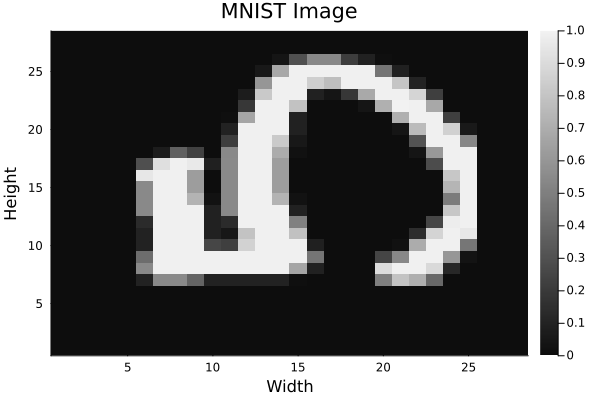

In [24]:
# Get the first batch from the test dataloader
x_batch = first(test_dataloader)[1]

# Extract the first sample and reshape it to 28×28×1×1
single_sample = x_batch[:, :, :, 25]

println("Shape of single sample: ", size(single_sample))

heatmap(single_sample[:, :, 1], c=:grays, title="MNIST Image", xlabel="Width", ylabel="Height")

In [28]:
# Get the first batch from the test dataloader
x_batch = first(test_dataloader)[1]

# Extract the 120th sample and reshape it to 28×28×1×1
single_sample = x_batch[:, :, :, 25]

println("Shape of single sample: ", size(single_sample))

# Plot the sample
heatmap(single_sample[:, :, 1], c=:grays, title="MNIST Image", xlabel="Width", ylabel="Height")

# Pass the sample through the model
predicted_class = onecold(Array(first(simple_chains_model(single_sample, ps, st))))
println("Predicted class: ", predicted_class-1)

Shape of single sample: (28, 28, 1)
Predicted class: 5


In [ ]:
Array(first(simple_chains_model(single_sample, ps, st)))

In [ ]:
methods(simple_chains_model)

In [ ]:
onecold(Array(first(simple_chains_model(single_sample, ps, st))))

In [ ]:
const lossfn = CrossEntropyLoss(; logits=Val(true))

function accuracy(model, ps, st, dataloader)
    total_correct, total = 0, 0
    st = Lux.testmode(st)
    for (x, y) in dataloader
        target_class = onecold(Array(y))
        predicted_class = onecold(Array(first(model(x, ps, st))))
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct / total
end

In [ ]:
input_data = reshape(imgs[:, :, 1], 28, 28, 1, 1)  # Reshape input to match model dimensions
output = simple_chains_model(input_data[1], ps, st)  # Pass input, parameters, and states
predicted_class = onecold(Array(output))  # Convert output to class predictions
println("Predicted class: ", predicted_class)

In [ ]:
input_data = reshape(imgs, 28,28, 1,1);

In [ ]:
output = lux_model(input_data, ps, st)
onecold(Array(first(lux_model(input_data, ps, st))))

# Otro tutorial más básico para regresión lineal

https://lux.csail.mit.edu/stable/tutorials/beginner/1_Basics

# Construcción de redes a la medida